# Reading the time series 

In [58]:
import requests
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime  
from datetime import timedelta 
url="http://192.168.250.101:4242/api/query?start=2021/01/01&m=last:1d-last:BR_PAR{GH_BUCKET=31,BRCODE=166,GOV_ID=70}"
headers = {'content-type': 'application/vnd.kafka.v1+json'}
r = requests.get(url, headers=headers)


In [63]:
r.text

'[{"metric":"BR_PAR","tags":{"GH_BUCKET":"31","GOV_ID":"75","BRCODE":"101"},"aggregateTags":[],"dps":{"1609459200":100.0,"1609545600":100.0,"1609632000":100.0,"1609718400":100.0,"1609804800":100.0,"1609891200":100.0,"1609977600":100.0,"1610064000":100.0,"1610150400":100.0,"1610236800":100.0,"1610323200":100.0,"1610409600":100.0,"1610496000":100.0,"1610582400":100.0,"1610668800":100.0,"1610755200":100.0,"1610841600":100.0,"1610928000":100.0,"1611014400":100.0,"1611100800":100.0,"1611187200":100.0,"1611273600":100.0,"1611360000":100.0,"1611446400":100.0,"1611532800":100.0,"1611619200":100.0,"1611705600":100.0,"1611792000":100.0,"1611878400":100.0,"1611964800":100.0,"1612051200":100.0,"1612137600":100.0,"1612224000":100.0,"1612310400":100.0,"1612396800":100.0,"1612483200":100.0,"1612569600":100.0,"1612656000":100.0,"1612742400":100.0,"1612828800":100.0,"1612915200":100.0,"1613001600":100.0,"1613088000":100.0,"1613174400":100.0,"1613260800":100.0,"1613347200":100.0,"1613433600":100.0,"1613

In [75]:
d = (yaml.safe_load(r.text)[0]['tags']['BRCODE'])
d

'101'

In [67]:
d = (yaml.safe_load(r.text)[10]['dps'])
ts_data = pd.DataFrame(list(d.items()))
ts_data.columns = ['time', 'risk_percentage']
ts_data['time']=pd.to_datetime(ts_data['time'], unit='s')
ts_data = ts_data.sort_values(by=['time'])
ts_data

,time,risk_percentage
0,2021-01-01,10.35
1,2021-01-02,10.04
2,2021-01-03,10.07
3,2021-01-04,10.02
4,2021-01-05,10.09
...,...,...
83,2021-03-25,8.43
84,2021-03-26,8.43
85,2021-03-27,8.38
86,2021-03-28,8.34


In [69]:
import plotly.express as px

fig = px.line(ts_data, x="time", y="risk_percentage")
fig.show()

# The period used to update forecasting "SMOOTHING"[1/12/2020 TO 1/1/2021)

In [8]:
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/12/2020','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/1/2021','%d/%m/%Y'))]
ts_data.head()

,time,risk_percentage
0,2020-11-22,3.85
1,2020-11-23,3.85
2,2020-11-24,3.93
3,2020-11-25,3.96
4,2020-11-26,3.95


# AUTO ARIMA MODEL 

In [9]:
###### 1/1/2021
from pmdarima.arima import auto_arima

L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/10/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/12/2020','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    arima_model = auto_arima(df,n_fits=50,with_intercept='auto',trace=True)
    period = datetime.strptime(str(1)+'/1/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/12/2020','%d/%m/%Y')
    x= period.days
    prediction= arima_model.predict(n_preiods=x)
    L.append(prediction[-1])
    periods.append(period)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12.296, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12.340, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13.548, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-13.429, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46.266, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-13.369, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7.965, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.210 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-15.795, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14.271, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16.968, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-16.576, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.748, Time=0.01 sec

# Real value And calculating error

In [17]:
real = ts_data[(ts_data['time'].dt.day == 1) & (ts_data['time'].dt.month == 1)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)
##### calculate the error 
e =[]
for i in range(len(L)):
    e.append(abs(real-L[i]))

In [18]:
tt=[]
for i in range(1,len(whole)+1):
    tt.append(str(i)+'/12/2020')
tt= pd.to_datetime(tt,format= '%d/%m/%Y')
tt


DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq=None)

In [22]:
real

7.517

In [21]:
L

[8.316917961480472,
 8.298591596494548,
 8.30384126780702,
 8.301825711787595,
 8.303104476976646,
 8.29581257720139,
 8.289598343488084,
 8.290543326109683,
 8.286480498935116,
 8.282516374112507,
 8.284347414812038,
 8.283384121324175,
 8.281098472405318,
 8.273463394514952,
 8.242303586768665,
 8.236489571371731,
 8.207298107134955,
 8.23265246306789,
 8.234998910723299,
 8.199799772625996,
 7.981416831717165,
 7.975769323225061,
 7.926696455158695,
 7.892295275326304,
 7.931305175602031,
 7.963963294146654,
 7.884522810635037,
 7.76550301574243,
 7.659849522667415,
 7.565596106341645,
 7.430571687624199]

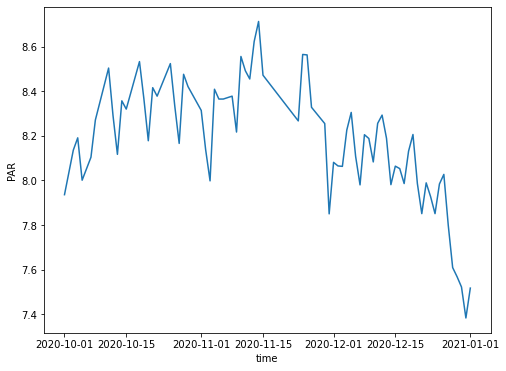

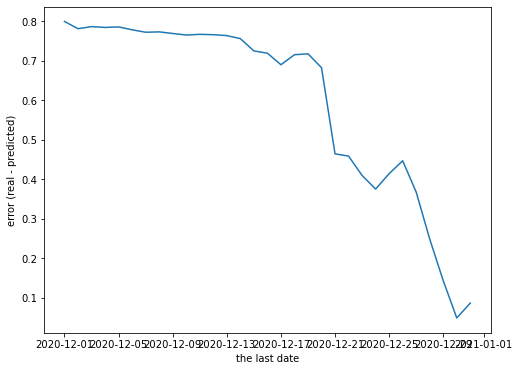

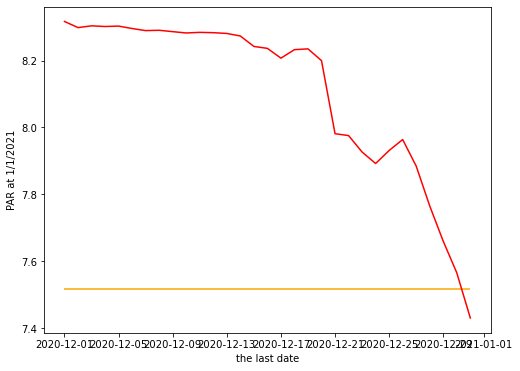

In [20]:
#### plotting for 1/1/2021
fig,ax1 = plt.subplots(nrows=1,ncols=1)
after_start_date = ts_data["time"] >= datetime.strptime('1/10/2020','%d/%m/%Y')
before_end_date = ts_data["time"] <= datetime.strptime('1/1/2021','%d/%m/%Y')
between_two_dates = after_start_date & before_end_date
df = ts_data.loc[between_two_dates]
ax1.plot(df['time'],df['risk_percentage'])
ax1.set_xlabel('time')
ax1.set_ylabel('PAR')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(tt, e)
ax2.set_xlabel('the last date')
ax2.set_ylabel('error (real - predicted)')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax3 = plt.subplots(nrows=1,ncols=1)
ax3.hlines(real,xmin=min(tt),xmax=max(tt),color='orange')
ax3.plot(tt,L,color='red')
ax3.set_xlabel('the last date')
ax3.set_ylabel('PAR at 1/1/2021')
fig.set_figheight(6)
fig.set_figwidth(8)


# The period used to update forecasting "SMOOTHING"[1/1/2021 TO 1/2/2021)

In [24]:
##### 1/2/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/1/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/2/2021','%d/%m/%Y'))]
ts_data.head()
from pmdarima.arima import auto_arima

L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/11/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/1/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    arima_model = auto_arima(df,n_fits=50,with_intercept='auto',trace=True)
    period = datetime.strptime(str(1)+'/2/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/1/2021','%d/%m/%Y')
    x= period.days
    prediction= arima_model.predict(n_preiods=x)
    L.append(prediction[-1])
    periods.append(period)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38.317, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.500, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.789, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-37.182, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.041, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-40.194, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-40.730, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-40.226, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38.288, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-40.870, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-38.046, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-40.678, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-40.973, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-38.978, 

In [25]:
real = ts_data[(ts_data['time'].dt.day == 1) & (ts_data['time'].dt.month == 2)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)
##### calculate the error 
e =[]
for i in range(len(L)):
    e.append(abs(real-L[i]))

In [26]:
tt=[]
for i in range(1,len(whole)+1):
    tt.append(str(i)+'/1/2021')
tt= pd.to_datetime(tt,format= '%d/%m/%Y')
tt


DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31'],
              dtype='datetime64[ns]', freq=None)

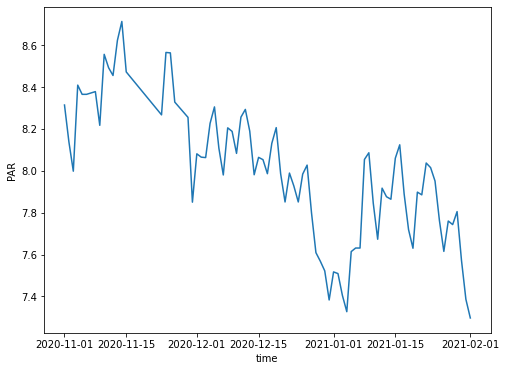

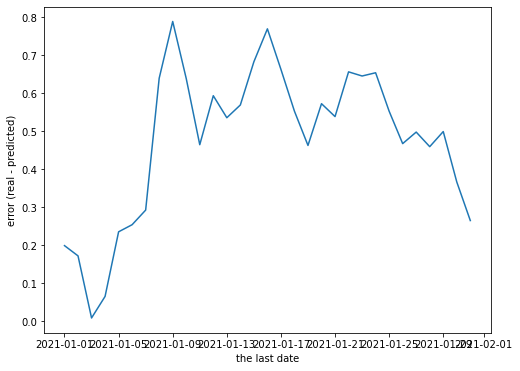

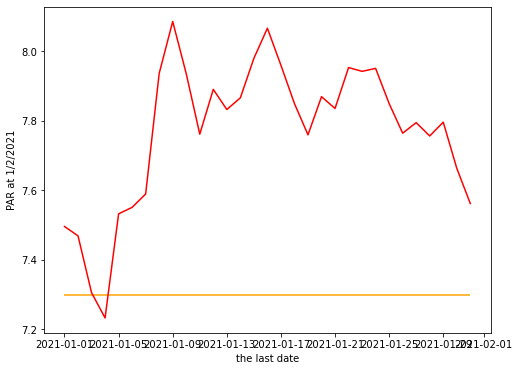

In [27]:
#### plotting for 1/2/2021
fig,ax1 = plt.subplots(nrows=1,ncols=1)
after_start_date = ts_data["time"] >= datetime.strptime('1/11/2020','%d/%m/%Y')
before_end_date = ts_data["time"] <= datetime.strptime('1/2/2021','%d/%m/%Y')
between_two_dates = after_start_date & before_end_date
df = ts_data.loc[between_two_dates]
ax1.plot(df['time'],df['risk_percentage'])
ax1.set_xlabel('time')
ax1.set_ylabel('PAR')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(tt, e)
ax2.set_xlabel('the last date')
ax2.set_ylabel('error (real - predicted)')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax3 = plt.subplots(nrows=1,ncols=1)
ax3.hlines(real,xmin=min(tt),xmax=max(tt),color='orange')
ax3.plot(tt,L,color='red')
ax3.set_xlabel('the last date')
ax3.set_ylabel('PAR at 1/2/2021')
fig.set_figheight(6)
fig.set_figwidth(8)

# The period used to update forecasting "SMOOTHING"[1/2/2021 TO 1/3/2021)

In [10]:
##### 1/3/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/2/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/3/2021','%d/%m/%Y'))]
ts_data.head()
from pmdarima.arima import auto_arima

L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    arima_model = auto_arima(df,n_fits=50,with_intercept='auto')
    period = datetime.strptime(str(1)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    x= period.days
    prediction= arima_model.predict(n_preiods=period)
    L.append(prediction[-1])
    periods.append(period)

In [11]:
real = ts_data[(ts_data['time'].dt.day == 1) & (ts_data['time'].dt.month == 3)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)
e =[]
for i in range(len(L)):
    e.append(abs(real-L[i]))
tt=[]
for i in range(1,len(whole)+1):
    tt.append(str(i)+'/2/2021')
tt= pd.to_datetime(tt,format= '%d/%m/%Y')
tt


DatetimeIndex(['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
               '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08',
               '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28'],
              dtype='datetime64[ns]', freq=None)

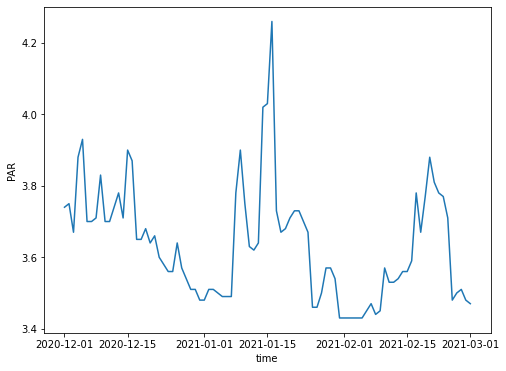

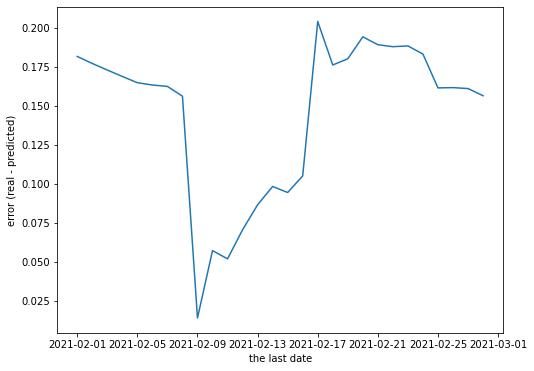

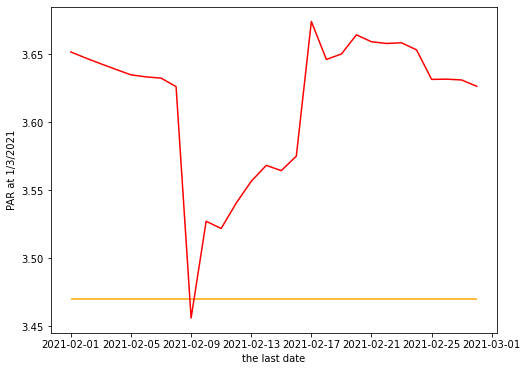

In [12]:
#### plotting for 1/3/2021
fig,ax1 = plt.subplots(nrows=1,ncols=1)
after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
before_end_date = ts_data["time"] <= datetime.strptime('1/3/2021','%d/%m/%Y')
between_two_dates = after_start_date & before_end_date
df = ts_data.loc[between_two_dates]
ax1.plot(df['time'],df['risk_percentage'])
ax1.set_xlabel('time')
ax1.set_ylabel('PAR')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(tt, e)
ax2.set_xlabel('the last date')
ax2.set_ylabel('error (real - predicted)')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax3 = plt.subplots(nrows=1,ncols=1)
ax3.hlines(real,xmin=min(tt),xmax=max(tt),color='orange')
ax3.plot(tt,L,color='red')
ax3.set_xlabel('the last date')
ax3.set_ylabel('PAR at 1/3/2021')
fig.set_figheight(6)
fig.set_figwidth(8)

In [13]:
L

[3.6515139413230147,
 3.6470263609978195,
 3.6428103052735903,
 3.638696935054286,
 3.63469774923406,
 3.63320689319281,
 3.6323171770649307,
 3.6260701607057073,
 3.4560618091815836,
 3.5271044242146905,
 3.5218218608974743,
 3.540469627440583,
 3.5564779919727623,
 3.568194009440834,
 3.564329670642858,
 3.5749740464276885,
 3.6739358330236898,
 3.646039887729488,
 3.650023471157065,
 3.6641037957309175,
 3.659028097381558,
 3.6577681081608384,
 3.6582810376895094,
 3.653035245079024,
 3.6313725955591702,
 3.631546952322854,
 3.630937340261001,
 3.626335906126062]

In [14]:
real

3.47

In [35]:
print(f'max error{max(e)} , min error{min(e)}')

max error0.5809999999999995 , min error0.012078599513184685


# Holt's winter 

In [51]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
##### 1/3/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/2/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/3/2021','%d/%m/%Y'))]
ts_data.head()
L = []
periods = []
for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    model = ExponentialSmoothing(np.asarray(df['risk_percentage']), initialization_method="estimated" ,trend='add',seasonal='add',seasonal_periods=7,damped_trend=True)
    period = datetime.strptime(str(1)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    model._index = pd.to_datetime(df.index)
    fit = model.fit(optimized=True)
    x= int(period.days)
    prediction= fit.predict(x)
    L.append(prediction[-1])
    periods.append(period)
 

In [52]:
real = ts_data[(ts_data['time'].dt.day == 1) & (ts_data['time'].dt.month == 3)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)

e =[]
for i in range(len(L)):
    e.append(abs(real-L[i]))
tt=[]
for i in range(1,len(whole)+1):
    tt.append(str(i)+'/2/2021')
tt= pd.to_datetime(tt,format= '%d/%m/%Y')


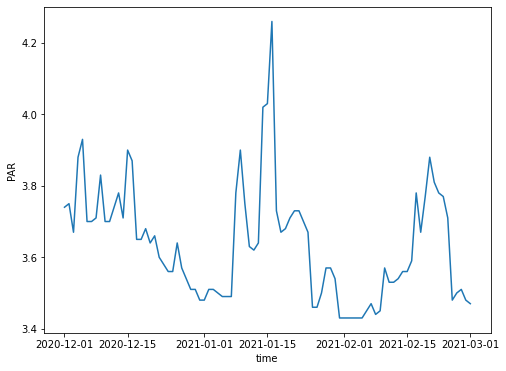

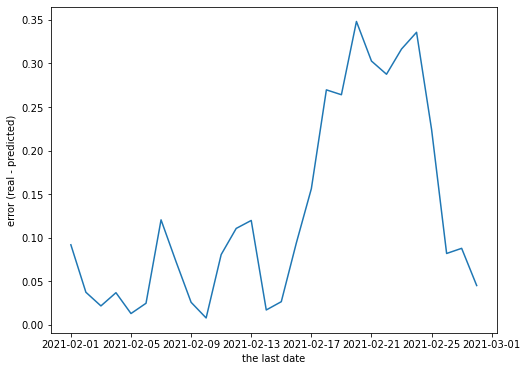

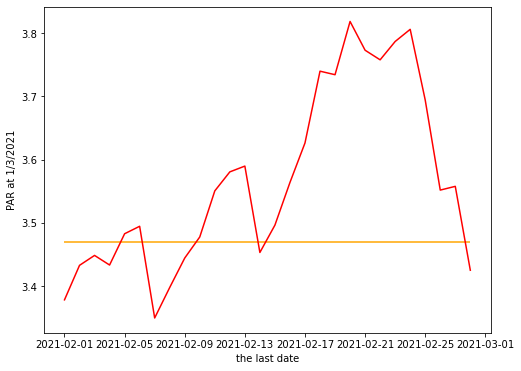

In [53]:
#### plotting for 1/3/2021
fig,ax1 = plt.subplots(nrows=1,ncols=1)
after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
before_end_date = ts_data["time"] <= datetime.strptime('1/3/2021','%d/%m/%Y')
between_two_dates = after_start_date & before_end_date
df = ts_data.loc[between_two_dates]
ax1.plot(df['time'],df['risk_percentage'])
ax1.set_xlabel('time')
ax1.set_ylabel('PAR')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(tt, e)
ax2.set_xlabel('the last date')
ax2.set_ylabel('error (real - predicted)')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax3 = plt.subplots(nrows=1,ncols=1)
ax3.hlines(real,xmin=min(tt),xmax=max(tt),color='orange')
ax3.plot(tt,L,color='red')
ax3.set_xlabel('the last date')
ax3.set_ylabel('PAR at 1/3/2021')
fig.set_figheight(6)
fig.set_figwidth(8)

In [13]:
# sum of squares 
import math
res = math.sqrt(sum(map(lambda i : i * i, e)))
  
# printing result
print ("The sum of squares of list is : " + str(res))

The sum of squares of list is : 2.0439940918552377


# CONVLSTM

# GRID SEARCH 

In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array

In [2]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
# define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
# fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
# make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# LSTM 

In [10]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [11]:
dataset= ts_data.set_index('time')
dataset = dataset.astype('float32')

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
## split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


84 42


In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset = pd.DataFrame(dataset)
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 0])
        
    return numpy.array(dataX), numpy.array(dataY)

In [17]:
#### the model itself
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [18]:
#### to create test data for period I already have created
def datetime_range(start: datetime, end: datetime, step: timedelta) :
    
    return [start + i * step for i in range((end - start) // step)]




In [19]:
##### 1/3/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/2/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/3/2021','%d/%m/%Y'))]
ts_data.head()
L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    period = datetime.strptime(str(1)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    x = int(period.days)
    dataset = df
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # reshape input to be [samples, time steps, features]
    trainX, trainY = create_dataset(dataset, look_back)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    testX= pd.DataFrame(datetime_range(datetime.strptime('1/2/2021','%d/%m/%Y'), datetime.strptime('1/3/2021','%d/%m/%Y'), timedelta(days=1)))
    testX['y']=0
    testX['time'] = testX.iloc[:,0]
    testX= testX.iloc[:,1:]
    tsetX = testX.set_index('time')
    testX,testY= create_dataset(testX, look_back)
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict= model.predict(testX)
    # invert predictions
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    prediction = testPredict
    L.append(prediction[-1])
    periods.append(period)

Epoch 1/100
61/61 - 0s - loss: 0.0840
Epoch 2/100
61/61 - 0s - loss: 0.0551
Epoch 3/100
61/61 - 0s - loss: 0.0395
Epoch 4/100
61/61 - 0s - loss: 0.0323
Epoch 5/100
61/61 - 0s - loss: 0.0295
Epoch 6/100
61/61 - 0s - loss: 0.0284
Epoch 7/100
61/61 - 0s - loss: 0.0278
Epoch 8/100
61/61 - 0s - loss: 0.0273
Epoch 9/100
61/61 - 0s - loss: 0.0270
Epoch 10/100
61/61 - 0s - loss: 0.0265
Epoch 11/100
61/61 - 0s - loss: 0.0261
Epoch 12/100
61/61 - 0s - loss: 0.0256
Epoch 13/100
61/61 - 0s - loss: 0.0252
Epoch 14/100
61/61 - 0s - loss: 0.0248
Epoch 15/100
61/61 - 0s - loss: 0.0245
Epoch 16/100
61/61 - 0s - loss: 0.0242
Epoch 17/100
61/61 - 0s - loss: 0.0238
Epoch 18/100
61/61 - 0s - loss: 0.0234
Epoch 19/100
61/61 - 0s - loss: 0.0233
Epoch 20/100
61/61 - 0s - loss: 0.0229
Epoch 21/100
61/61 - 0s - loss: 0.0224
Epoch 22/100
61/61 - 0s - loss: 0.0221
Epoch 23/100
61/61 - 0s - loss: 0.0222
Epoch 24/100
61/61 - 0s - loss: 0.0217
Epoch 25/100
61/61 - 0s - loss: 0.0214
Epoch 26/100
61/61 - 0s - loss: 0.

In [38]:
##### 30/3/2021 I will try it later
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/3/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('30/3/2021','%d/%m/%Y'))]
ts_data.head()
L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/1/2021','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/3/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    period = datetime.strptime(str(30)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/3/2021','%d/%m/%Y')
    x = int(period.days)
    dataset = df
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # reshape input to be [samples, time steps, features]
    trainX, trainY = create_dataset(dataset, look_back)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    testX= pd.DataFrame(datetime_range(datetime.strptime('1/3/2021','%d/%m/%Y'), datetime.strptime('30/3/2021','%d/%m/%Y'), timedelta(days=1)))
    testX['y']=0
    testX['time'] = testX.iloc[:,0]
    testX= testX.iloc[:,1:]
    tsetX = testX.set_index('time')
    testX,testY= create_dataset(testX, look_back)
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict= model.predict(testX)
    # invert predictions
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    prediction = testPredict
    L.append(prediction[-1])
    periods.append(period)

Epoch 1/100
58/58 - 0s - loss: 0.0161
Epoch 2/100
58/58 - 0s - loss: 0.0159
Epoch 3/100
58/58 - 0s - loss: 0.0158
Epoch 4/100
58/58 - 0s - loss: 0.0158
Epoch 5/100
58/58 - 0s - loss: 0.0158
Epoch 6/100
58/58 - 0s - loss: 0.0159
Epoch 7/100
58/58 - 0s - loss: 0.0160
Epoch 8/100
58/58 - 0s - loss: 0.0159
Epoch 9/100
58/58 - 0s - loss: 0.0158
Epoch 10/100
58/58 - 0s - loss: 0.0158
Epoch 11/100
58/58 - 0s - loss: 0.0158
Epoch 12/100
58/58 - 0s - loss: 0.0159
Epoch 13/100
58/58 - 0s - loss: 0.0159
Epoch 14/100
58/58 - 0s - loss: 0.0158
Epoch 15/100
58/58 - 0s - loss: 0.0159
Epoch 16/100
58/58 - 0s - loss: 0.0161
Epoch 17/100
58/58 - 0s - loss: 0.0158
Epoch 18/100
58/58 - 0s - loss: 0.0159
Epoch 19/100
58/58 - 0s - loss: 0.0157
Epoch 20/100
58/58 - 0s - loss: 0.0158
Epoch 21/100
58/58 - 0s - loss: 0.0158
Epoch 22/100
58/58 - 0s - loss: 0.0159
Epoch 23/100
58/58 - 0s - loss: 0.0159
Epoch 24/100
58/58 - 0s - loss: 0.0159
Epoch 25/100
58/58 - 0s - loss: 0.0159
Epoch 26/100
58/58 - 0s - loss: 0.

In [36]:
whole = ts_data[(ts_data['time']>=datetime.strptime('1/3/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('30/3/2021','%d/%m/%Y'))]
ts_data.head()
len(whole)


29

In [39]:
L

[array([3.454964], dtype=float32),
 array([3.452004], dtype=float32),
 array([3.4459], dtype=float32),
 array([3.444591], dtype=float32),
 array([3.4447134], dtype=float32),
 array([3.4436016], dtype=float32),
 array([3.4284344], dtype=float32),
 array([3.341996], dtype=float32),
 array([3.3147657], dtype=float32),
 array([3.3170516], dtype=float32),
 array([3.2938783], dtype=float32),
 array([3.2859647], dtype=float32),
 array([3.3074765], dtype=float32),
 array([3.3091736], dtype=float32),
 array([3.3087935], dtype=float32),
 array([3.3072424], dtype=float32),
 array([3.3114717], dtype=float32),
 array([3.3018703], dtype=float32),
 array([3.325908], dtype=float32),
 array([3.319971], dtype=float32),
 array([3.3167326], dtype=float32),
 array([3.3148236], dtype=float32),
 array([3.3238251], dtype=float32),
 array([3.3278182], dtype=float32),
 array([3.31841], dtype=float32),
 array([3.3282049], dtype=float32),
 array([3.3205464], dtype=float32),
 array([3.3237324], dtype=float32),
 ar

In [42]:
real = ts_data[(ts_data['time'].dt.day == 29) & (ts_data['time'].dt.month == 3)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)
real

3.52

In [20]:
real = ts_data[(ts_data['time'].dt.day == 1) & (ts_data['time'].dt.month == 3)& (ts_data['time'].dt.year == 2021)]['risk_percentage']
real= float(real)
e =[]
for i in range(len(L)):
    e.append(abs(real-L[i]))
tt=[]
for i in range(1,len(whole)+1):
    tt.append(str(i)+'/2/2021')
tt= pd.to_datetime(tt,format= '%d/%m/%Y')

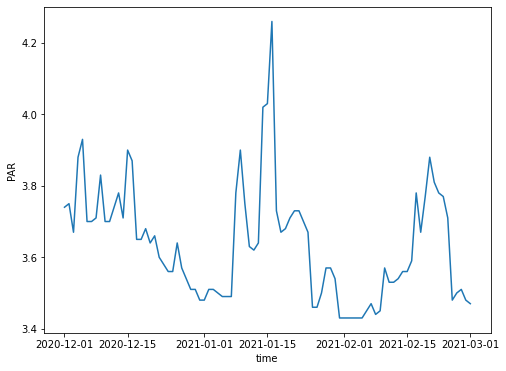

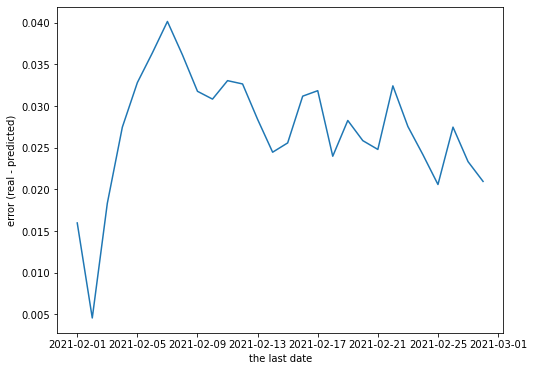

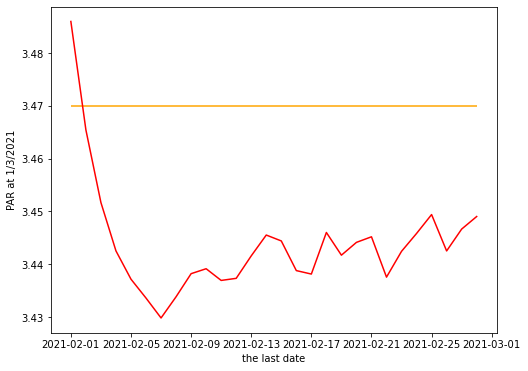

In [21]:
#### plotting for 1/3/2021
fig,ax1 = plt.subplots(nrows=1,ncols=1)
after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
before_end_date = ts_data["time"] <= datetime.strptime('1/3/2021','%d/%m/%Y')
between_two_dates = after_start_date & before_end_date
df = ts_data.loc[between_two_dates]
ax1.plot(df['time'],df['risk_percentage'])
ax1.set_xlabel('time')
ax1.set_ylabel('PAR')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax2 = plt.subplots(nrows=1,ncols=1)
ax2.plot(tt, e)
ax2.set_xlabel('the last date')
ax2.set_ylabel('error (real - predicted)')
fig.set_figheight(6)
fig.set_figwidth(8)
fig,ax3 = plt.subplots(nrows=1,ncols=1)
ax3.hlines(real,xmin=min(tt),xmax=max(tt),color='orange')
ax3.plot(tt,L,color='red')
ax3.set_xlabel('the last date')
ax3.set_ylabel('PAR at 1/3/2021')
fig.set_figheight(6)
fig.set_figwidth(8)


In [22]:
real

3.47

In [23]:
L

[array([3.4859686], dtype=float32),
 array([3.4654434], dtype=float32),
 array([3.4516854], dtype=float32),
 array([3.4425366], dtype=float32),
 array([3.437181], dtype=float32),
 array([3.4336069], dtype=float32),
 array([3.429839], dtype=float32),
 array([3.433856], dtype=float32),
 array([3.438225], dtype=float32),
 array([3.4391615], dtype=float32),
 array([3.4369464], dtype=float32),
 array([3.4373422], dtype=float32),
 array([3.4415932], dtype=float32),
 array([3.4455383], dtype=float32),
 array([3.4444225], dtype=float32),
 array([3.4388084], dtype=float32),
 array([3.4381514], dtype=float32),
 array([3.4460218], dtype=float32),
 array([3.4417272], dtype=float32),
 array([3.4441502], dtype=float32),
 array([3.4452057], dtype=float32),
 array([3.4375708], dtype=float32),
 array([3.4424543], dtype=float32),
 array([3.44584], dtype=float32),
 array([3.4494157], dtype=float32),
 array([3.4425268], dtype=float32),
 array([3.4466658], dtype=float32),
 array([3.4490452], dtype=float32)

In [32]:
print(f'max error{max(e)} , min error{min(e)}')

max error[0.3114624] , min error[0.16808653]


# CNNLSTM

In [122]:
##1- define the model 
from numpy import array
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [166]:
##### 1/3/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/2/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/3/2021','%d/%m/%Y'))]
ts_data.head()
L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    period = datetime.strptime(str(1)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    x = int(period.days)
    # reshape input to be [samples, time steps, features]
    n_steps = 3
    X,y = split_sequence(np.array(df), n_steps)
    #X = X.reshape((X.shape[0], X.shape[1], n_features))
    print(X)
    #model.fit(X, y, epochs=1000, verbose=0)
    

IndexError: index 1 is out of bounds for axis 1 with size 1

In [147]:
len(np.array(ts_data))

328

In [ ]:
testX= pd.DataFrame(datetime_range(datetime.strptime('1/2/2021','%d/%m/%Y'), datetime.strptime('1/3/2021','%d/%m/%Y'), timedelta(days=1)))
    x_input =  np.asarray(testX).astype('float32')
    x_input = x_input.reshape((len(x_input), 1, n_features))
    # invert predictions
    prediction = model.predict(x_input, verbose=0)
    L.append(prediction[-1])
    periods.append(period)

In [133]:
testX= pd.DataFrame(datetime_range(datetime.strptime('1/2/2021','%d/%m/%Y'), datetime.strptime('1/3/2021','%d/%m/%Y'), timedelta(days=1)))
#x_input = array(list(testX))
array(litestX))

array([0])

In [138]:
list(ts_data)

['time', 'risk_percentage']

# ConvLSTM 

In [110]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset = pd.DataFrame(dataset)
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 0])
        
    return numpy.array(dataX), numpy.array(dataY)

In [111]:
##### 1/3/2021
from datetime import datetime
whole = ts_data[(ts_data['time']>=datetime.strptime('1/2/2021','%d/%m/%Y'))&(ts_data['time']<datetime.strptime('1/3/2021','%d/%m/%Y'))]
ts_data.head()
L = []
periods = []

for i in range(1,len(whole)+1):
    after_start_date = ts_data["time"] >= datetime.strptime('1/12/2020','%d/%m/%Y')
    before_end_date = ts_data["time"] <= datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    between_two_dates = after_start_date & before_end_date
    df = ts_data.loc[between_two_dates]
    df['risk_percentage'].map(lambda x : float(x))
    df.set_index('time',inplace=True)
    period = datetime.strptime(str(1)+'/3/2021','%d/%m/%Y')-datetime.strptime(str(i)+'/2/2021','%d/%m/%Y')
    x = int(period.days)
      
    # reshape input to be [samples, time steps, features]
    trainX, trainY = create_dataset(df, look_back=1)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    model.fit(trainX,trainY, epochs=500, verbose=0)
    testX= pd.DataFrame(datetime_range(datetime.strptime('1/2/2021','%d/%m/%Y'), datetime.strptime('1/3/2021','%d/%m/%Y'), timedelta(days=1)))
    testX['y']=0
    testX['time'] = testX.iloc[:,0]
    testX= testX.iloc[:,1:]
    tsetX = testX.set_index('time')
    testX,testY= create_dataset(testX, look_back)
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict= model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    prediction = testPredict
    L.append(prediction[-1])
    periods.append(period)

ValueError: in user code:

    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\mashraf\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: [None, 1, 1]
